In [4]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
plt.style.use(["science", "notebook", "grid"])
import os

## Translation Normalization
We translate the hand landmarks so that a specific point (usually the wrist or the center of the palm) is at the origin (0,0,0).

In [2]:
def translate_landmarks(landmarks, reference_point_index):
    """
    Translate the hand landmarks so that the reference point is at the origin.

    :param landmarks: NumPy array of shape (N, 3) representing hand landmarks.
    :param reference_point_index: Index of the landmark to use as the new origin.
    :return: Translated landmarks as a NumPy array.
    """
    # Get the reference point coordinates
    reference_point = landmarks[reference_point_index]

    # Translate all landmarks so that the reference point is at the origin
    translated_landmarks = landmarks - reference_point
    
    return translated_landmarks

## Scale Normalization
We scale the landmarks so that the hand size is consistent across all samples. This can be done by ensuring that the maximum distance between any two landmarks is the same for all hands.

In [ ]:
def scale_landmarks(landmarks, desired_max_distance = 1):
    """
    Scale the hand landmarks so that the maximum distance between any two landmarks
    is equal to desired_max_distance.

    :param landmarks: NumPy array of shape (N, 3) representing hand landmarks.
    :param desired_max_distance: The desired maximum distance between any two landmarks. Default value is 1.
    :return: Scaled landmarks as a NumPy array.
    """
    # Compute all pairwise distances
    distances = np.linalg.norm(landmarks[:, np.newaxis] - landmarks[np.newaxis, :], axis=2)

    # Find the maximum distance in the current set of landmarks
    current_max_distance = distances.max()

    # Calculate the scale factor
    scale_factor = desired_max_distance / current_max_distance

    # Scale the landmarks
    scaled_landmarks = landmarks * scale_factor
    
    return scaled_landmarks

## Extract Hand Landmarks with MediaPipe

In [4]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.6)

def extract_landmarks(image_path):
    """
    Extract hand landmarks from the given image.

    :param image_path: Path to the image file.
    :return: A NumPy array of landmarks.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        # Extract landmarks for the first hand detected
        landmarks = results.multi_hand_landmarks[0].landmark
        # Convert landmarks to a NumPy array
        landmarks_array = np.array([(lm.x, lm.y, lm.z) for lm in landmarks])
        return landmarks_array
    return None

I0000 00:00:1721720163.589772       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Preprocess the Landmarks
Integrate the normalization functions

In [5]:
def preprocess_landmarks(landmarks, reference_point_index, desired_max_distance):
    """
    Preprocess the landmarks by translating and scaling.

    :param landmarks: NumPy array of landmarks.
    :param reference_point_index: Index of the landmark to use as the reference point for translation.
    :param desired_max_distance: The desired maximum distance between any two landmarks after scaling.
    :return: Preprocessed landmarks.
    """
    translated_landmarks = translate_landmarks(landmarks, reference_point_index)
    scaled_landmarks = scale_landmarks(translated_landmarks, desired_max_distance)
    return scaled_landmarks

## Creating Graph data
To prepare the graph data from hand landmarks, where nodes represent each landmark and edges are represented as an adjacency matrix, we follow these steps:

- **Extract Hand Landmarks:** Use an approach like MediaPipe to get the landmarks.
- **Create Nodes:** Each landmark becomes a node in the graph.
- **Create Edges:** Define edges based on the anatomical connections between landmarks, which can be represented using an adjacency matrix.

In [6]:
# Define connections based on MediaPipe's hand model
connections = mp.solutions.hands.HAND_CONNECTIONS

def create_hand_graph(landmarks, connections = connections):
    """
    Create a graph from the extracted hand landmarks.

    :param landmarks: A NumPy array of landmarks.
    :return: A graph and its adjacency matrix.
    """
    G = nx.Graph()
    for idx, landmark in enumerate(landmarks):
        G.add_node(idx, pos=(landmark[0], landmark[1], landmark[2]))

    for connection in connections:
        G.add_edge(connection[0], connection[1])

    adjacency_matrix = nx.to_numpy_array(G)
    return G, adjacency_matrix

## Creating Features
1. Angles Between Joints: Calculate the angles between joints in the hand using the landmarks.
Calculating the angles between joints in a hand involves determining the angle formed at a joint by the two segments of the finger leading to that joint. 
    - Select Three Points: For any given joint, we need three points to calculate the angle: the point before the joint, the joint itself, and the point after the joint.
    - Calculate the Vectors: Form two vectors from these points: one from the first point to the joint and another from the joint to the third point.
    - Compute the Angle: Use the dot product between these vectors to calculate the angle at the joint.

In [7]:
def calculate_angle(point1, point2, point3):
    """
    Calculate the angle formed by three points.

    :param point1: The first point as a tuple (x, y, z).
    :param point2: The second point (the joint) as a tuple (x, y, z).
    :param point3: The third point as a tuple (x, y, z).
    :return: The angle in radians.
    """
    # Create vectors from the points
    vector1 = np.array(point1) - np.array(point2)
    vector2 = np.array(point3) - np.array(point2)

    # Normalize the vectors
    vector1_norm = vector1 / np.linalg.norm(vector1)
    vector2_norm = vector2 / np.linalg.norm(vector2)

    # Compute the dot product
    dot_product = np.dot(vector1_norm, vector2_norm)

    # Ensure the dot product is within the range [-1, 1] for acos
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Calculate the angle in radians and then convert to degrees
    angle_rad = np.arccos(dot_product)

    return angle_rad

To calculate the angles between the joints using the function calculate_angle described earlier, we need to identify the points that form each angle we are interested in. In the context of a hand, we want to calculate the angles at each finger joint, which requires the positions of the joints and the adjacent landmarks.

Here’s how we can proceed to calculate the angles between the joints for a hand:

- Identify the Landmark Indices for Joints: Using the hand model (like MediaPipe’s), identify the indices of landmarks that represent joints and their adjacent points.
- Calculate Angles for Each Joint: Use these indices to extract the coordinates of the relevant points and calculate the angles.
<img src="https://www.researchgate.net/publication/362871842/figure/fig1/AS:11431281084350163@1663153181104/MediaPipe-Hands-21-landmarks-13.ppm">

In [8]:
# MediaPipe hand landmark model indices for finger joints
# These indices may need to be adjusted based on the exact landmark model we are using
finger_joints = {
        'thumb_cmc': (1, 2, 3),
        'thumb_mcp': (2, 3, 4),
        'index_finger_mcp': (5, 6, 7),
        'index_finger_pip': (6, 7, 8),
        'middle_finger_mcp': (9, 10, 11),
        'middle_finger_pip': (10, 11, 12),
        'ring_finger_mcp': (13, 14, 15),
        'ring_finger_pip': (14, 15, 16),
        'pinky_mcp': (17, 18, 19),
        'pinky_pip': (18, 19, 20)
    }

def calculate_all_finger_angles(landmarks, finger_joints = finger_joints):
    """
    Calculate angles for all finger joints using the landmarks.

    :param landmarks: A list of (x, y, z) tuples representing the hand landmarks.
    :return: A dictionary with joint names as keys and their angles in degrees as values.
    """

    angles = {}
    for joint, (p1, p2, p3) in finger_joints.items():
        angle = calculate_angle(landmarks[p1], landmarks[p2], landmarks[p3])
        angles[joint] = angle

    return angles

## Example Usage

In [10]:
# Path to your image
image_path = "/Volumes/Extreme SSD/American_Sign_Language/data/raw_data/asl_alphabet_train/B/B422.jpg"

# Extract landmarks
landmarks = extract_landmarks(image_path)
if landmarks is not None:
    # Preprocess landmarks
    # Using the wrist (index 0 in MediaPipe's landmarks) as the reference point
    preprocessed_landmarks = preprocess_landmarks(landmarks, 0, 1.0)  # assuming we want the max distance to be 1
else:
    print("No hand detected in the image.")

In [11]:
if preprocessed_landmarks is not None:
    # Create graph and adjacency matrix from landmarks
    hand_graph, adjacency_matrix = create_hand_graph(preprocessed_landmarks)

    print("Graph Nodes:", hand_graph.number_of_nodes())
    print("Adjacency Matrix:\n", adjacency_matrix)
else:
    print("No hand detected in the image.")

Graph Nodes: 21
Adjacency Matrix:
 [[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [12]:
joint_angles = calculate_all_finger_angles(landmarks)

for joint, angle in joint_angles.items():
    print(f"{joint}: {angle:.2f} rad")

thumb_cmc: 2.21 rad
thumb_mcp: 2.40 rad
index_finger_mcp: 2.95 rad
index_finger_pip: 3.05 rad
middle_finger_mcp: 2.98 rad
middle_finger_pip: 3.06 rad
ring_finger_mcp: 3.08 rad
ring_finger_pip: 3.07 rad
pinky_mcp: 3.00 rad
pinky_pip: 3.08 rad


## Visualize the Graph: 
Add a function to visualize the graph using the positions of the landmarks as node positions.

In [19]:
def visualize_hand_graph(G, ax):
    """
    Visualize the hand graph using matplotlib.

    :param G: A networkx graph of hand landmarks.
    """
    pos = nx.get_node_attributes(G, 'pos')

    # Since 'pos' contains (x, y, z), we need to convert it to 2D
    pos_2d = {node: (coords[0], coords[1]) for node, coords in pos.items()}


    nx.draw(G, pos=pos_2d, with_labels=True, node_color='skyblue', edge_color='k', node_size=500, font_weight='bold', ax = ax)
    ax.set_title("Hand Landmarks Graph (Inverted)")

Text(0.5, 1.0, 'Original Image')

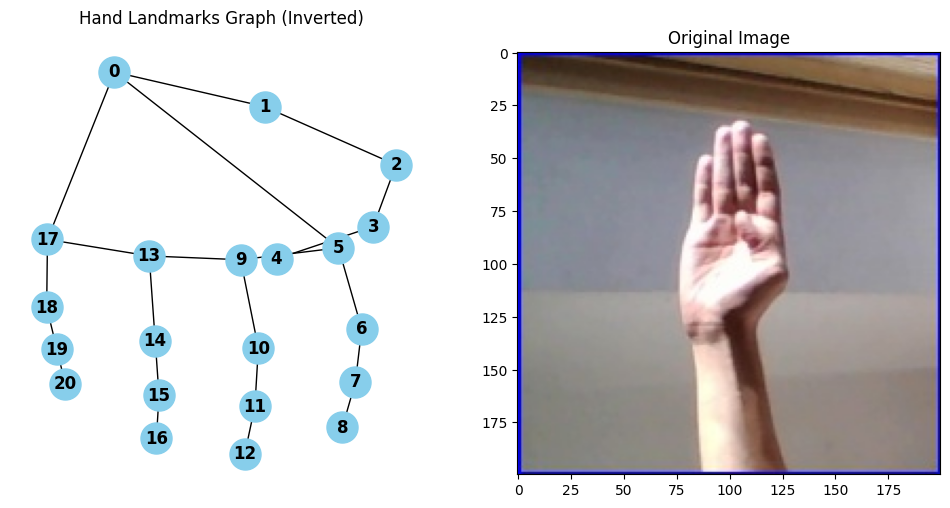

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
visualize_hand_graph(hand_graph, ax[0])
ax[1].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
ax[1].set_title("Original Image")

## Final Workflow

In [24]:
def preprocess_image(image_path: str) -> np.ndarray:
    """ Preprocess the image for inference. 
    Args:
        image_path (str): Path to the image file.
    Returns:
        np.ndarray: preprocessed landmarks, adjacency matrix, and joint angles.
    """
    # Extract landmarks
    try:
        landmarks = extract_landmarks(image_path)
    except:
        landmarks = None
    if landmarks is not None:
        # Preprocess landmarks
        # Using the wrist (index 0 in MediaPipe's landmarks) as the reference point
        preprocessed_landmarks = preprocess_landmarks(landmarks, 0, 1.0)  # assuming we want the max distance to be 1
    
    if preprocessed_landmarks is not None:
        # Create graph and adjacency matrix from landmarks
        hand_graph, adjacency_matrix = create_hand_graph(preprocessed_landmarks)

    joint_angles = calculate_all_finger_angles(landmarks)

    return preprocessed_landmarks, adjacency_matrix, joint_angles

In [25]:
def save_data(data, path, filename):
    """
    Save data to a file in an efficient format.
    Numpy arrays are saved directly, while sparse matrices are saved in a compressed format.

    :param data: Data to be saved, either a numpy array or a scipy sparse matrix.
    :param path: Directory path where the file will be saved.
    :param filename: Filename for saving the data.
    """
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, filename)

    # Check if the data is a sparse matrix and save accordingly
    if isinstance(data, csr_matrix):
        save_npz(file_path, data)
    else:
        np.save(file_path, data)

def process_images(root_dir, output_root_dir):
    img_num, failed_attempts = 0, 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_num += 1
                if img_num % 1000 == 0:
                    print(f"Processed {img_num} images")

                image_path = os.path.join(dirpath, filename)

                # Extract the label from the path
                label = os.path.basename(dirpath)

                # Preprocess the image and get numpy arrays for landmarks, adjacency matrix, and angles
                try:
                    landmarks, adj_matrix, angles = preprocess_image(image_path)
                except Exception as e:
                    failed_attempts += 1
                    if failed_attempts % 1000 == 0:
                        print(f"Error processing image {image_path}: {e}, failed attempts: {failed_attempts}")
                    continue

                # Convert the adjacency matrix to a sparse matrix
                sparse_adj_matrix = csr_matrix(adj_matrix)

                # Define output paths for each data type
                landmarks_path = os.path.join(output_root_dir, 'landmarks', label)
                adj_matrix_path = os.path.join(output_root_dir, 'adj_matrix', label)
                angles_path = os.path.join(output_root_dir, 'angles', label)

                # Create a unique filename based on the original image name
                base_filename = os.path.splitext(filename)[0]
                save_data(landmarks, landmarks_path, f'{base_filename}_landmarks.npy')
                save_data(sparse_adj_matrix, adj_matrix_path, f'{base_filename}_adj_matrix.npz')
                save_data(angles, angles_path, f'{base_filename}_angles.npy')


In [26]:
## Usage
root_directory_path = "/Users/archismanchakraborti/Desktop/American_Sign_Language/data/raw_data/asl_alphabet_train"
output_directory_path = "/Users/archismanchakraborti/Desktop/American_Sign_Language/data/processed_data"

process_images(root_directory_path, output_directory_path)

Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Error processing image /Users/archismanchakraborti/Desktop/American_Sign_Language/data/raw_data/asl_alphabet_train/U/U47.jpg: cannot access local variable 'preprocessed_landmarks' where it is not associated with a value, failed attempts: 1000
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Error processing image /Users/archismanchakraborti/Desktop/American_Sign_Language/data/raw_data/asl_alphabet_train/N/N2589.jpg: cannot access local variable 'preprocessed_landmarks' where it is not associated with a value, failed attempts: 2000
Processed 10000 images
Processed 11000 images
Error processing image /Users/archismanchakraborti/Desktop/American_Sign_Language/data/raw_data/asl_alphabet_train/N/N668.jpg: cannot access local variable 'preprocessed_landmarks' where it is not associated with a value, failed attempts: 3000
Processed 12000 images
P

## Combining features
To combine the landmark coordinates and joint angles into a single feature matrix, ywe will create a function that takes the landmarks and joint angles as inputs along with a mapping from landmarks to angles.


- **Extend the Landmark Matrix:** For landmarks that correspond to joints with angles, append the angle to the landmark’s feature vector. For landmarks without a corresponding angle, append a zero or a null placeholder.
- **Create a Unified Feature Matrix:** Ensure that each row in the matrix represents a landmark with its coordinates and, if applicable, the corresponding joint angle.

**Final feature matrix shape: (num_of_landmarks, num_of_features):** (21, 4) -> 21 landmarks, 4 columns for x, y, z, angle. 


In [27]:
def combine_features(landmarks, joint_angles, angle_indices):
    """
    Combine landmarks and joint angles into a single feature matrix.

    :param landmarks: Numpy array of landmarks with shape (21, 3).
    :param joint_angles: Dictionary of joint angles with joint names as keys and angle values.
    :param angle_indices: Dictionary mapping joint names to landmark indices.
    :return: Extended feature matrix with shape (21, 4) where the last column contains the joint angles.
    """
    # Extend the landmarks array to include an extra column for the angles
    extended_features = np.hstack([landmarks, np.zeros((landmarks.shape[0], 1))])

    # Iterate over the joint angles and insert them into the extended feature matrix
    for joint, index in angle_indices.items():
        # Fetch the angle value from the joint_angles dictionary
        angle = joint_angles.get(joint, 0)  # Default to 0 if the joint is not in the dictionary
        # Update the corresponding row in the extended feature matrix
        extended_features[index, -1] = angle  # -1 accesses the last column

    return extended_features

In [28]:
angle_indices = {
    'thumb_cmc': 2,  # Angle at landmark 2, formed between landmarks 1, 2, and 3
    'thumb_mcp': 3,  # Angle at landmark 3, formed between landmarks 2, 3, and 4
    'index_finger_mcp': 6,  # Angle at landmark 6, formed between landmarks 5, 6, and 7
    'index_finger_pip': 7,  # Angle at landmark 7, formed between landmarks 6, 7, and 8
    'middle_finger_mcp': 10,  # Angle at landmark 10, formed between landmarks 9, 10, and 11
    'middle_finger_pip': 11,  # Angle at landmark 11, formed between landmarks 10, 11, and 12
    'ring_finger_mcp': 14,  # Angle at landmark 14, formed between landmarks 13, 14, and 15
    'ring_finger_pip': 15,  # Angle at landmark 15, formed between landmarks 14, 15, and 16
    'pinky_mcp': 18,  # Angle at landmark 18, formed between landmarks 17, 18, and 19
    'pinky_pip': 19  # Angle at landmark 19, formed between landmarks 18, 19, and 20
}

# Combine landmarks and angles for the first hand in the image
extended_features = combine_features(preprocessed_landmarks, joint_angles, angle_indices)
extended_features

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.23602423, -0.12130797, -0.09546243,  0.        ],
       [ 0.42135766, -0.42179987, -0.10970529,  2.72214252],
       [ 0.45631443, -0.68325598, -0.1193007 ,  2.89427117],
       [ 0.43298481, -0.89370157, -0.1175655 ,  0.        ],
       [ 0.24462242, -0.62498056, -0.02806616,  0.        ],
       [ 0.28114158, -0.80797597, -0.15703938,  1.01221913],
       [ 0.2551867 , -0.64105317, -0.22978659,  2.82942482],
       [ 0.23449957, -0.46412055, -0.24705017,  0.        ],
       [ 0.07554163, -0.58791501, -0.01883944,  0.        ],
       [ 0.1047335 , -0.78124022, -0.16405147,  0.82997324],
       [ 0.0993673 , -0.564938  , -0.20404284,  2.85831748],
       [ 0.10300175, -0.36876307, -0.18491048,  0.        ],
       [-0.08525076, -0.53027223, -0.0318922 ,  0.        ],
       [-0.05921542, -0.6674447 , -0.18780381,  0.80199573],
       [-0.03360524, -0.42993362, -0.16883274,  2.86362517],
       [-0.01270491, -0.

In [29]:
def process_and_combine(root_dir, output_dir) -> None:
    """ Process landmarks and angles for each image and combine them into a single feature matrix.
    Args:
        root_dir (str): Root directory containing the landmarks and angles.
        output_dir (str): Output directory for saving the extended features.
    Returns:
        None"""
    angles_dir = os.path.join(root_dir, 'angles')
    landmarks_dir = os.path.join(root_dir, 'landmarks')

    files_processed = 0 # Counter for tracking the number of files processed
    
    for class_name in os.listdir(landmarks_dir):
        class_landmarks_path = os.path.join(landmarks_dir, class_name)
        class_angles_path = os.path.join(angles_dir, class_name)
        output_class_path = os.path.join(output_dir, 'extended_features', class_name)

        # Ensure the output directory exists
        os.makedirs(output_class_path, exist_ok=True)

        for filename in os.listdir(class_landmarks_path):
            if filename.endswith('_landmarks.npy'):
                files_processed += 1
                if files_processed % 100 == 0:
                    print(f"Processed {files_processed} files")

                # Construct the file paths for landmarks and angles
                landmarks_file_path = os.path.join(class_landmarks_path, filename)
                angle_file_name = filename.replace('landmarks', 'angles')
                angle_file_path = os.path.join(class_angles_path, angle_file_name)

                # Load the landmarks and angles numpy arrays
                landmarks = np.load(landmarks_file_path)
                angles = np.load(angle_file_path, allow_pickle=True).item()

                # Combine the features
                combined = combine_features(landmarks, angles, angle_indices)

                # Save the combined features
                output_filename = filename.replace('landmarks', 'extended_features')
                np.save(os.path.join(output_class_path, output_filename), combined)

In [30]:
root_dir = "/Users/archismanchakraborti/Desktop/American_Sign_Language/data/processed_data"
output_dir = root_dir
process_and_combine(root_dir, output_dir)

Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Processed 1500 files
Processed 1600 files
Processed 1700 files
Processed 1800 files
Processed 1900 files
Processed 2000 files
Processed 2100 files
Processed 2200 files
Processed 2300 files
Processed 2400 files
Processed 2500 files
Processed 2600 files
Processed 2700 files
Processed 2800 files
Processed 2900 files
Processed 3000 files
Processed 3100 files
Processed 3200 files
Processed 3300 files
Processed 3400 files
Processed 3500 files
Processed 3600 files
Processed 3700 files
Processed 3800 files
Processed 3900 files
Processed 4000 files
Processed 4100 files
Processed 4200 files
Processed 4300 files
Processed 4400 files
Processed 4500 files
Processed 4600 files
Processed 4700 files
Processed 4800 files
P

In [9]:
processed_dir = "/Volumes/Extreme SSD/American_Sign_Language/data/processed_data/adj_matrix"

# Count thenumber of files in each sub-dir of the processed data
n_files = {}
for class_name in os.listdir(processed_dir):
    class_path = os.path.join(processed_dir, class_name)
    num_files = len(os.listdir(class_path))
    n_files[class_name] = num_files

Text(0.5, 1.0, 'Number of Files in Each Class')

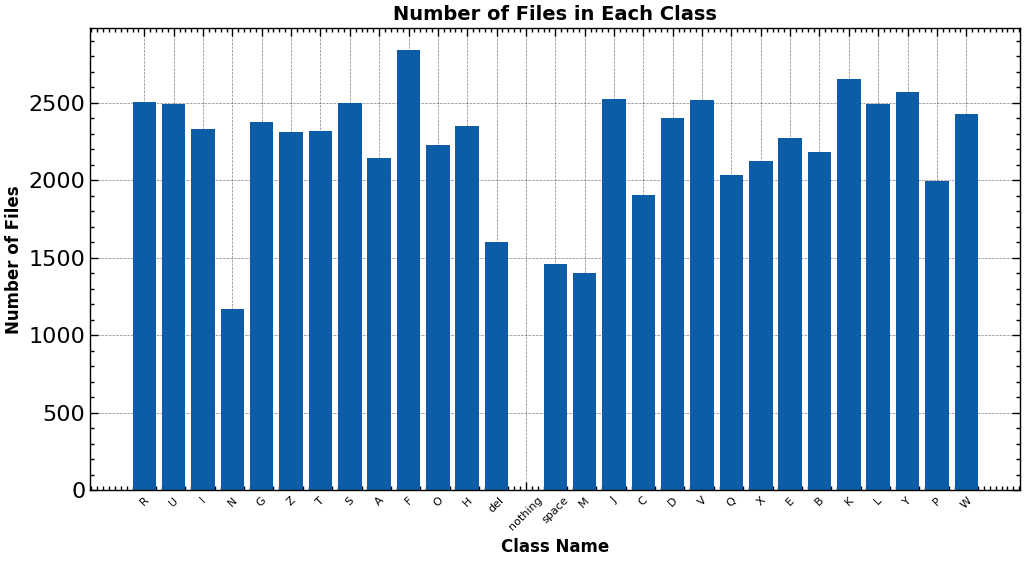

In [10]:
# Plot with a bar chart with rotated x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(n_files.keys(), n_files.values())
plt.xticks(rotation=45, fontsize = 8)
plt.xlabel('Class Name', fontsize=12, fontweight='bold')
plt.ylabel('Number of Files', fontsize=12, fontweight='bold')
plt.title('Number of Files in Each Class', fontsize=14, fontweight='bold')

In [7]:
n_files["nothing"] = 1823